In [27]:
import pandas as pd
import numpy as np
import plot_utils
import cptac
import cptac.utils as u
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
en = cptac.Endometrial()
col = cptac.Colon()
br = cptac.Brca()

In [4]:
sig = pd.read_csv('~/WhenMutationsDontMatter/PIK3CA/csv_files/proteomics_sig.csv', index_col=0)
sig.head()

,Difference_In_Median_Brca,P_Value_Brca,Difference_In_Median_Endo,P_Value_Endo,Difference_In_Median,P_Value
A2ML1,NaN,NaN,1.10585,0.037044,NaN,NaN
AADAT,-1.33200,0.027477,NaN,NaN,NaN,NaN
AAGAB,NaN,NaN,NaN,NaN,0.139,0.039189
AASDHPPT,0.51445,0.003620,NaN,NaN,NaN,NaN
AATF,-0.16905,0.042271,NaN,NaN,NaN,NaN


In [78]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


In [6]:
proteomics = br.get_proteomics(tissue_type="tumor")
fil = proteomics.columns.get_level_values('Name').duplicated(False)
duplicates = proteomics[proteomics.columns[fil]]
no_duplicates = proteomics[proteomics.columns[~fil]]
# no_duplicates

In [7]:
#FOR NO DUPLICATES
#Flatten the multiindex (since there are no duplicate gene names, this won't be a problem)
no_duplicates = br.reduce_multiindex(no_duplicates, flatten=True)

#get mutation_tyoe
mut_type = br.get_genotype_all_vars('PIK3CA')

#join proteomics and mutation type
joined = mut_type.join(no_duplicates)

#select samples containing hotspot mutations
br_hotspot_df = joined[joined.Location.str.contains('E542K') | 
                    joined.Location.str.contains('E545K') |
                    joined.Location.str.contains('H1047R')]


#join wildtype proteomics to missense mutation proteomics 
wildtype  = joined.loc[joined.Mutation == "Wildtype_Tumor"]
brca_hotspot = br_hotspot_df.append(wildtype)

#drop unncessary columns
prot_and_mutations = brca_hotspot.drop(columns = ["Mutation_Status", "Location"])

# Get the difference in medians
missense = prot_and_mutations[prot_and_mutations.Mutation == "Missense_Mutation"] #get all missense_mutations
wt = prot_and_mutations[prot_and_mutations.Mutation == "Wildtype_Tumor"] #getn all wildtype
missense_med = missense.median() #get the medain of the missense. This will give the median expression among all samples, for each gene
wt_med = wt.median() #get the median of the wildtype


no_dup_d = {}

for prot in no_duplicates:
    dif_brca = missense_med[prot] - wt_med[prot]
    no_dup_d[prot] = dif_brca

median_diff = pd.DataFrame.from_dict(no_dup_d, orient='index', columns=['Difference_In_Median'])

#Do a t test for every gene and report the p-value
genes = list(prot_and_mutations.columns[1:])
t_test = u.wrap_ttest(prot_and_mutations, 'Mutation', genes, return_all = True)
t_test = t_test.set_index('Comparison')

#join median and p value together
no_dup_df = median_diff.join(t_test)
# no_dup_df.head()

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 83 samples for the PIK3CA gene (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 394)
/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:153: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals <= alphacBonf
/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:257: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


In [8]:
#DEALING WITH DUPLICATES
#flatten the multiindex
duplicates = br.reduce_multiindex(duplicates, flatten=True)

# We need to figure which of databaseID we want to use, for each protein
proteomics = br.get_proteomics(tissue_type="tumor")
fil = proteomics.columns.get_level_values('Name').duplicated(False)
duplicates = proteomics[proteomics.columns[fil]]
duplicate_gene_names = list(set(duplicates.columns.get_level_values('Name'))) #get a list of genes names that are duplicated
duplicates = br.reduce_multiindex(duplicates, flatten=True)
duplicates

#  Step 1 - Create dataframe in order to do comparisons with wrap_ttest

mut_type = br.get_genotype_all_vars("PIK3CA")


joined = mut_type.join(duplicates)

#select samples containing hotspot mutations
br_hotspot_df = joined[joined.Location.str.contains('E542K') | 
                    joined.Location.str.contains('E545K') |
                    joined.Location.str.contains('H1047R')]


#join wildtype proteomics to missense mutation proteomics 
wildtype  = joined.loc[joined.Mutation == "Wildtype_Tumor"]
brca_hotspot = br_hotspot_df.append(wildtype)

#drop unncessary columns
prot_and_mutations = brca_hotspot.drop(columns = ["Mutation_Status", "Location"])


# get the difference in medians
missense = prot_and_mutations[prot_and_mutations.Mutation == "Missense_Mutation"] #get all missense_mutations
wt = prot_and_mutations[prot_and_mutations.Mutation == "Wildtype_Tumor"] #getn all wildtype
missense_med = missense.median() #get the medain of the missense. This will give the median expression among all samples, for each gene
wt_med = wt.median() #get the median of the wildtype


duplicates_d = {}

for prot in duplicates:
    dif_brca =  missense_med[prot] - wt_med[prot]
    duplicates_d[prot] = dif_brca
    

median_diff = pd.DataFrame.from_dict(duplicates_d, orient='index', columns=['Difference_In_Median'])


#step 3 do a t test for every gene and report the p-value
cols = list(prot_and_mutations.columns[1:])
t_test = u.wrap_ttest(prot_and_mutations, 'Mutation', cols, return_all = True)
t_test = t_test.set_index('Comparison')

# Step 4 join median and p value together
dup_df = median_diff.join(t_test)
# dup_df.head()

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 83 samples for the PIK3CA gene (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 394)


In [9]:
#for each duplicated gene name select the one with the min p val and append to no_duplicat df
for name in duplicate_gene_names:
    gene_duplicate = dup_df[dup_df.index.str.contains(name)]
    #select the one with the min p value for t test
    min_row = gene_duplicate[gene_duplicate.P_Value == gene_duplicate.P_Value.min()]
    #append the selected version onto no_duplicate dataframe
    no_dup_df=no_dup_df.append(min_row)
no_dup_df=no_dup_df.sort_index()
# no_dup_df.head()

In [10]:
def get_df(cancer_df):
    #mutation type is PIK3CA's
    #proteomics is the new gene
    mut = cancer_df.get_genotype_all_vars("PIK3CA", mutation_hotspot=['E542K', 'E545K', 'H1047R'])
    prot = cancer_df.get_proteomics(tissue_type="tumor")
    joined = mut.join(prot)
    joined

    hotspot_df = joined[joined.Location.str.contains('E542K') | 
                        joined.Location.str.contains('E545K') |
                        joined.Location.str.contains('H1047R')]

    wildtype  = joined.loc[joined.Mutation == "Wildtype_Tumor"]

    hotspot = hotspot_df.append(wildtype)


    prot_and_mutations = hotspot.drop(columns = ["Mutation_Status", "Location"])
    return (prot_and_mutations)



In [11]:
def get_brca_gene(br, gene):
    mut = br.get_genotype_all_vars("PIK3CA", mutation_hotspot=['E542K', 'E545K', 'H1047R'])
    prot = br.get_proteomics(tissue_type="tumor")


    brca_selected_databaseID = no_dup_df[no_dup_df.index.str.contains(gene)].index
    brca_selected_databaseID

    flat = br.reduce_multiindex(prot, flatten=True)
    flat

    selected_gene = flat[brca_selected_databaseID]
    selected_gene

    split = selected_gene.columns.astype(str).str.split('_', 1).str[0]
    selected_gene.columns=split
    
    joined = mut.join(selected_gene)
    
    hotspot_df = joined[joined.Location.str.contains('E542K') | 
                        joined.Location.str.contains('E545K') |
                        joined.Location.str.contains('H1047R')]

    wildtype  = joined.loc[joined.Mutation == "Wildtype_Tumor"]

    hotspot = hotspot_df.append(wildtype)


    prot_and_mutations = hotspot.drop(columns = ["Mutation_Status", "Location"])
    return (prot_and_mutations)
   
    

# Run with different genes

In [38]:
gene="TNKS1BP1"

In [54]:
endo = get_df(en)
endo = endo[['Mutation', gene]]

colon = get_df(col)
colon = colon[['Mutation', gene]]

brca = get_brca_gene(br, gene)

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 48 samples for the PIK3CA gene (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 394)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 82 samples for the PIK3CA gene (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 394)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 05CO045 (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 394)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 83 samples for the PIK3CA gene (/Users/hannahb

In [94]:
#run t test
pval_endo = u.wrap_ttest(endo, 'Mutation', correction_method= "fdr_bh", return_all=True)
pval_colon = u.wrap_ttest(colon, 'Mutation', correction_method= "fdr_bh", return_all=True)
pval_brca = u.wrap_ttest(brca, 'Mutation', correction_method= "fdr_bh", return_all=True)

In [40]:
endo = endo.assign(cancer = 'Endometrial')
brca = brca.assign(cancer = 'Brca')
colon = colon.assign(cancer = 'Colon')
colon["Mutation"] = colon["Mutation"].replace("nonsynonymous SNV", "Missense_Mutation")
colon["Mutation"] = colon["Mutation"].replace("nonsynonymous SNV_hotspot", "Missense_Mutation")

In [57]:
endo.head()

Name,Mutation,TNKS1BP1
Patient_ID,,
C3L-00006,Missense_Mutation,-0.0439
C3L-00032,Missense_Mutation,0.2800
C3L-00362,Missense_Mutation,-0.0824
C3L-00601,Missense_Mutation,-0.3240
C3L-00605,Missense_Mutation,0.0720


In [42]:
colon

Name,Mutation,TNKS1BP1,cancer
Patient_ID,,,
05CO028,Missense_Mutation,0.1520,Colon
05CO032,Missense_Mutation,0.0047,Colon
09CO005,Missense_Mutation,0.2070,Colon
11CO027,Missense_Mutation,0.3260,Colon
11CO052,Missense_Mutation,-0.1330,Colon
...,...,...,...
20CO001,Wildtype_Tumor,0.2880,Colon
20CO003,Wildtype_Tumor,-0.0665,Colon
22CO004,Wildtype_Tumor,0.1210,Colon


In [43]:
brca

Name,Mutation,TNKS1BP1,cancer
Patient_ID,,,
CPT001846,Missense_Mutation,0.6802,Brca
X11BR004,Missense_Mutation,0.8018,Brca
X11BR013,Missense_Mutation,-1.1419,Brca
X11BR014,Missense_Mutation,1.0062,Brca
X11BR022,Missense_Mutation,0.9839,Brca
...,...,...,...
X15BR003,Wildtype_Tumor,1.4640,Brca
X18BR004,Wildtype_Tumor,-0.4619,Brca
X18BR006,Wildtype_Tumor,0.8096,Brca


In [44]:
df = endo.append(brca)
df = df.append(colon)
df

Name,Mutation,TNKS1BP1,cancer
Patient_ID,,,
C3L-00006,Missense_Mutation,-0.0439,Endometrial
C3L-00032,Missense_Mutation,0.2800,Endometrial
C3L-00362,Missense_Mutation,-0.0824,Endometrial
C3L-00601,Missense_Mutation,-0.3240,Endometrial
C3L-00605,Missense_Mutation,0.0720,Endometrial
...,...,...,...
20CO001,Wildtype_Tumor,0.2880,Colon
20CO003,Wildtype_Tumor,-0.0665,Colon
22CO004,Wildtype_Tumor,0.1210,Colon


In [93]:
pval_endo

,Comparison,P_Value
0,TNKS1BP1,0.423315


In [95]:
pval_brca

,Comparison,P_Value
0,TNKS1BP1,0.049705


In [96]:
pval_colon

,Comparison,P_Value
0,TNKS1BP1,0.027159


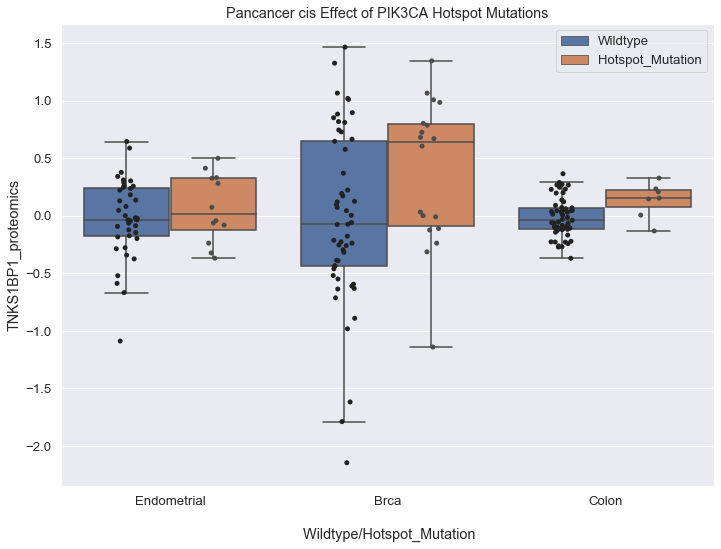

In [80]:
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='cancer', y=gene, data = df, hue = 'Mutation',
                      hue_order = ["Wildtype_Tumor", "Missense_Mutation"], showfliers = False)    
boxplot.set_title('Pancancer cis Effect of PIK3CA Hotspot Mutations')
boxplot = sns.stripplot(x='cancer', y=gene, data = df, jitter = True, 
                           color = ".3", hue = 'Mutation', hue_order = ["Wildtype_Tumor", "Missense_Mutation"], dodge = True)
boxplot.set(xlabel = "\n Wildtype/Hotspot_Mutation", ylabel = gene+"_proteomics")

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles, ['Wildtype', 'Hotspot_Mutation'])



plt.show()
plt.clf()
plt.close()